WHY RNN ?
 flexible in terms who much sequential data we are going to use to make prediction (no sliding window here :) ) + no limited prior context


RNN PROBLEMS ==>
      In practise difficult to access info from many steps
      exmaple:
       The flights the airline was canceling were full.
       Assigning a high probability to was following airline is straightforward since airline
      provides a strong local context for the singular agreement. However, assigning an
      appropriate probability to were is quite difficult, not only because the plural flights
      is quite distant, but also because the singular noun airline is closer in the intervening
      context. Ideally, a network should be able to retain the distant information about
      plural flights until it is needed, while still processing the intermediate parts of the
      sequence correctly.
      One reason for the inability of RNNs to carry forward critical information is that
      the hidden layers, and, by extension, the weights that determine the values in the hidden layer, are being asked to perform two tasks simultaneously: provide information
      useful for the current decision, and updating and carrying forward information required for future decisions.
      A second difficulty with training RNNs arises from the need to backpropagate
      the error signal back through time. Recall from Section 9.1.2 that the hidden layer at
      time t contributes to the loss at the next time step since it takes part in that calculation. As a result, during the backward pass of training, the hidden layers are subject
      to repeated multiplications, as determined by the length of the sequence. A frequent
      result of this process is that the gradients are eventually driven to zero, a situation
      vanishing gradients called the vanishing gradients problem.

Also the vanishing / exploding gradients problem ==>
  input1  * w2(weight between 2 unrolled networks) power num of unrolls  
  w2 > 1 Input 1 will explode ==> model will become too difficult to converge and may overshoot the minima which will lead (m4 hn3rf ngeeb el optimal w , b)

  w2< 1 vanishing grad prob ==> baby steps in gd  
  also model cannot capture long term dependecies 3l4an ht3ml unrolls 22l  
  

Solution ==> GO TO LSTM AS IT DIVIDES CONTEXT MANAGMENT PROB TO 2 PARTS
1) Removing info not needed any more
2) adding info more likely needed for future decision making


LSTMS also have some challenges that need to be addressed when using them for time series. First, they require a large amount of data and computational resources to train and optimize, which can be costly and time-consuming. Second, they can suffer from the curse of dimensionality, which means that the performance of the network decreases as the number of input features or output variables increases. This can be mitigated by using feature selection or dimensionality reduction techniques, such as principal component analysis or autoencoders. Third, they can be sensitive to hyperparameters, such as the number of hidden units, the learning rate, or the activation function, which can affect the convergence and accuracy of the network. This can be solved by using grid search, random search, or Bayesian optimization methods, which can help to find the optimal combination of hyperparameters.

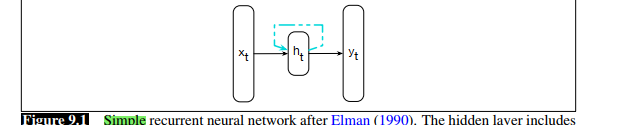

BY unrolling it through time axes

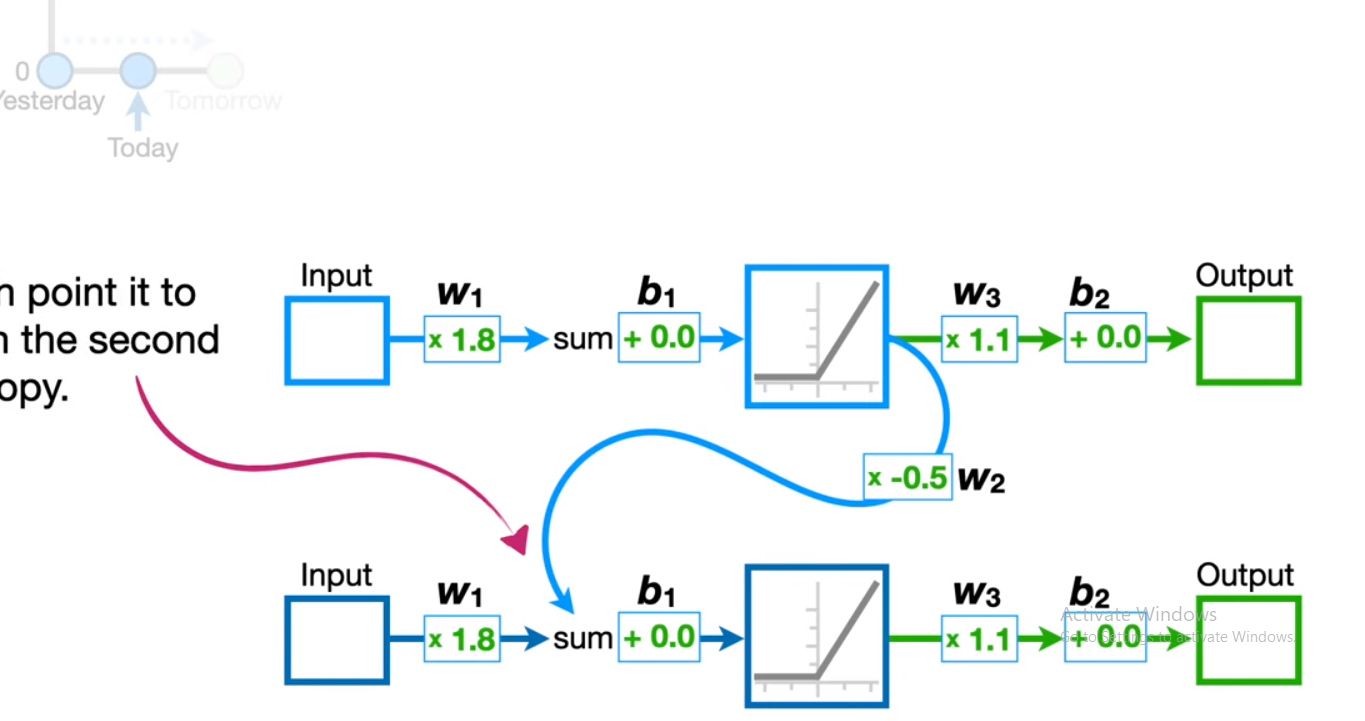

# Notebook for Programming in Problem 2


## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement long short-term memory (LSTM) for named entity recognition (NER). We will use the same dataset and boilerplate code as in Programming Problem 1 of Assignment #3.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to change function signatures, but be careful that you might need to also change how they are called in other parts of the notebook.

In [ ]:
!nvidia-smi # you may need to try reconnecting to get a T4 gpu

Mon Apr 29 21:16:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Installing PyTorch and Other Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.

In [ ]:
!pip install torch torchtext -f https://download.pytorch.org/whl/torch_stable.html

Test if our installation works:

In [ ]:
import torch

# Multiply two matrices on GPU
a = torch.rand(100, 200).cuda()
b = torch.rand(200, 100).cuda()
c = torch.matmul(a, b)

print("PyTorch successfully installed!")
print("Version:", torch.__version__)

PyTorch successfully installed!
Version: 2.2.1+cu121


Also install [scikit-learn](https://scikit-learn.org/stable/). We will use it for calculating evaluation metrics such as accuracy and F1 score.

In [ ]:
!pip install -U scikit-learn

Let's import all the packages at once:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import re
from collections import Counter
from typing import List, Tuple, Dict, Optional, Any

## Long Short Term Memory (LSTM)

### Data Loading

We will use the same dataset for named entity recognition in Assignment #2. First download the data and take a look at the first 50 lines:

In [ ]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.val
!cat eng.train | head -n 50

Each line corresponds to a word. Different sentences are separated by an additional line break. Take "EU NNP I-NP ORG" as an example. "EU" is a word. "NNP" and "I-NP" are tags for POS tagging and chunking, which we will ignore. "ORG" is the tag for NER, which is our prediction target. There are 5 possible values for the NER tag: ORG, PER, LOC, MISC, and O.



In [ ]:
# A sentence is a list of (word, tag) tuples.
# For example, [("hello", "O"), ("world", "O"), ("!", "O")]
Sentence = List[Tuple[str, str]]


def read_data_file(
    datapath: str,
) -> Tuple[List[Sentence], Dict[str, int], Dict[str, int]]:
    """
    Read and preprocess input data from the file `datapath`.
    Example:
    ```
        sentences, word_cnt, tag_cnt = read_data_file("eng.train")
    ```
    Return values:
        `sentences`: a list of sentences, including words and NER tags
        `word_cnt`: a Counter object, the number of occurrences of each word
        `tag_cnt`: a Counter object, the number of occurences of each NER tag
    """
    sentences: List[Sentence] = []
    word_cnt: Dict[str, int] = Counter()
    tag_cnt: Dict[str, int] = Counter()

    for sentence_txt in open(datapath).read().split("\n\n"):
        if "DOCSTART" in sentence_txt:
            # Ignore dummy sentences at the begining of each document.
            continue
        # Read a new sentence
        sentences.append([])
        for token in sentence_txt.split("\n"):
            w, _, _, t = token.split()
            # Replace all digits with "0" to reduce out-of-vocabulary words
            w = re.sub("\d", "0", w)
            word_cnt[w] += 1
            tag_cnt[t] += 1
            sentences[-1].append((w, t))

    return sentences, word_cnt, tag_cnt



In [ ]:
# Some helper code
def get_device() -> torch.device:
    """
    Use GPU when it is available; use CPU otherwise.
    See https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [ ]:
def eval_metrics(ground_truth: List[int], predictions: List[int]) -> Dict[str, Any]:
    """
    Calculate various evaluation metrics such as accuracy and F1 score
    Parameters:
        `ground_truth`: the list of ground truth NER tags
        `predictions`: the list of predicted NER tags
    """
    f1_scores = f1_score(ground_truth, predictions, average=None)
    return {
        "accuracy": accuracy_score(ground_truth, predictions),
        "f1": f1_scores,
        "average f1": np.mean(f1_scores),
        "confusion matrix": confusion_matrix(ground_truth, predictions),
    }

## Long Short-term Memory (LSTM)

Now we implement an one-layer LSTM for the same task and compare it to FFNNs.

### Data Loading **(4 points)**

Like before, we first implement the data loader. But unlike before, each data example is now a variable-length sentence. How can we pack multiple sentences with different lengths into the same batch? One possible solution is to pad them to the same length using a special token. The code below illustrates the idea:

In [ ]:
# 3 sentences with different lengths
sentence_1 = torch.tensor([6, 1, 2])
sentence_2 = torch.tensor([4, 2, 7, 7, 9])
sentence_3 = torch.tensor([3, 4])
# Form a batch by padding 0
sentence_batch = torch.tensor([
    [6, 1, 2, 0, 0],
    [4, 2, 7, 7, 9],
    [3, 4, 0, 0, 0],
])

We implement the above idea in a customized batching function `form_batch`. Optionally, see [here](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) for how batching works in PyTorch.

In [ ]:
class SequenceDataset(Dataset):
    """
    Each data example is a sentence, including its words and NER tags.
    """

    def __init__(
        self, datapath: str, words_vocab: Optional[Vocab] = None, tags_vocab: Optional[Vocab] = None
    ) -> None:
        """
        Initialize the dataset by reading from datapath.
        """
        super().__init__()
        self.sentences: List[Sentence] = []
        UNKNOWN = "<UNKNOWN>"
        PAD = "<PAD>"  # Special token used for padding

        print("Loading data from %s" % datapath)
        self.sentences, word_cnt, tag_cnt = read_data_file(datapath)
        print("%d sentences loaded." % len(self.sentences))

        if words_vocab is None:
            words_vocab = vocab(word_cnt, specials=[PAD, UNKNOWN])
            words_vocab.set_default_index(words_vocab[UNKNOWN])

        self.words_vocab = words_vocab

        self.unknown_idx = self.words_vocab[UNKNOWN]
        self.pad_idx = self.words_vocab[PAD]
        # print(f"Pad index => {self.pad_idx}" ) => 0

        # Print each tag and its index


        if tags_vocab is None:
            tags_vocab = vocab(tag_cnt, specials=[])

        self.tags_vocab = tags_vocab
        # for tag, idx in self.tags_vocab.items():
        #     print(f"Tag: {tag}, Index: {idx}")

    def __getitem__(self, idx: int) -> Sentence:
        """
        Get the idx'th sentence in the dataset.
        """
        return self.sentences[idx]

    def __len__(self) -> int:
        """
        Return the number of sentences in the dataset.
        """
        # TODO: Implement this method
        # START HERE
        return len(self.sentences)
        # raise NotImplementedError
        # END

    def form_batch(self, sentences: List[Sentence]) -> Dict[str, Any]:
        """
        A customized function for batching a number of sentences together.
        Different sentences have different lengths. Let max_len be the longest length.
        When packing them into one tensor, we need to pad all sentences to max_len.
        Return values:
            `words`: a list in which each element itself is a list of words in a sentence
            `word_idxs`: a batch_size x max_len tensor.
                       word_idxs[i][j] is the index of the j'th word in the i'th sentence .
            `tags`: a list in which each element itself is a list of tags in a sentence
            `tag_idxs`: a batch_size x max_len tensor
                      tag_idxs[i][j] is the index of the j'th tag in the i'th sentence.
            `valid_mask`: a batch_size x max_len tensor
                        valid_mask[i][j] is True if the i'th sentence has the j'th word.
                        Otherwise, valid[i][j] is False.
        """
        words: List[List[str]] = []
        tags: List[List[str]] = []
        max_len = -1  # length of the longest sentence
        for sent in sentences:
            words.append([])
            tags.append([])
            for w, t in sent:
                words[-1].append(w)
                tags[-1].append(t)
            max_len = max(max_len, len(words[-1]))

        batch_size = len(sentences)
        word_idxs = torch.full(
            (batch_size, max_len), fill_value=self.pad_idx, dtype=torch.int64
        )
        tag_idxs = torch.full_like(word_idxs, fill_value=self.tags_vocab["O"])
        valid_mask = torch.zeros_like(word_idxs, dtype=torch.bool)

        ## TODO: Fill in the values in word_idxs, tag_idxs, and valid_mask
        ## Caveat: There may be out-of-vocabulary words in validation data
        ## See torchtext.vocab.Vocab: https://pytorch.org/text/stable/vocab.html#torchtext.vocab.Vocab
        ## START HERE
        for  i  ,(word , tag) in enumerate ( zip (words , tags )   ) :
          # el mafrood word , tag kol wa7da fehom list bt represent sentence
          for j , (w ,t) in enumerate ( zip (word , tag) ) :
            word_idxs[i][j] = self.words_vocab[w] if w in self.words_vocab else self.unknown_idx
            # tyb what if w was OOV word eh el 3ml ? fe 7aga foo2 esmha self.unknown index 3l4an lw unknown word
            tag_idxs[i][j] = self.tags_vocab[t]
            # valid mask already ma3mola kolha false w lw l2eet validmask[i][j] 7otha b true lw ml2t4 j fe sent i kda kda hya b false
            valid_mask[i][j] = True

        # raise NotImplementedError

        # END
        # print(tag_idxs)
        return {
            "words": words,
            "word_idxs": word_idxs,
            "tags": tags,
            "tag_idxs": tag_idxs,
            "valid_mask": valid_mask,
        }


def create_sequence_dataloaders(
    batch_size: int, shuffle: bool = True
) -> Tuple[DataLoader, DataLoader, Vocab]:
    """
    Create the dataloaders for training and validaiton.
    """
    ds_train = SequenceDataset("eng.train")
    ds_val = SequenceDataset("eng.val", words_vocab=ds_train.words_vocab, tags_vocab=ds_train.tags_vocab)
    loader_train = DataLoader(
        ds_train,
        batch_size,
        shuffle,
        collate_fn=ds_train.form_batch,  # customized function for batching
        drop_last=True,
        pin_memory=True,
    )
    loader_val = DataLoader(
        ds_val, batch_size, collate_fn=ds_val.form_batch, pin_memory=True
    )
    return loader_train, loader_val, ds_train

Here is a simple sanity-check. Try to understand its output.

In [ ]:
def check_sequence_dataloader() -> None:
    loader_train, _, _ = create_sequence_dataloaders(batch_size=3, shuffle=False)
    print("Iterating on the training data..")
    for i, data_batch in enumerate(loader_train):
        if i == 0:
            print(data_batch)
    print("Done!")


check_sequence_dataloader()

Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
Iterating on the training data..
{'words': [['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn'], ['BRUSSELS', '0000-00-00']], 'word_idxs': tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10],
        [11, 12,  0,  0,  0,  0,  0,  0,  0],
        [13, 14,  0,  0,  0,  0,  0,  0,  0]]), 'tags': [['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'], ['PER', 'PER'], ['LOC', 'O']], 'tag_idxs': tensor([[0, 1, 2, 1, 1, 1, 2, 1, 1],
        [3, 3, 1, 1, 1, 1, 1, 1, 1],
        [4, 1, 1, 1, 1, 1, 1, 1, 1]]), 'valid_mask': tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False]])}
Done!


### Implement the Model **(8 points)**

Next, implement LSTM for predicting NER tags from input words. [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) is definitely useful. Further, it is tricky to handle sentences in the same batch with different lengths. Please read the PyTorch documentation in detail!


In [ ]:

class LSTM(nn.Module):
    """
    Long short-term memory for NER
    """

    def __init__(self, words_vocab: Vocab, tags_vocab: Vocab, d_emb: int, d_hidden: int, bidirectional: bool) -> None:
        """
        Initialize an LSTM
        Parameters:
            `words_vocab`: vocabulary of words
            `tags_vocab`: vocabulary of tags
            `d_emb`: dimension of word embeddings (D)
            `d_hidden`: dimension of the hidden layer (H)
            `bidirectional`: true if LSTM should be bidirectional
        """
        super().__init__()
        self.words_vocab = words_vocab
        self.tags_vocab = tags_vocab
        self.d_hidden = d_hidden
        self.bidirectional = bidirectional

        # Create word embeddings
        self.embedding = nn.Embedding(len(words_vocab), d_emb)

        # Create LSTM
        self.lstm = nn.LSTM(  d_emb, d_hidden, batch_first=True, bidirectional=bidirectional)
        #batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)


        # Create output layer
        num_directions = 2 if bidirectional else 1


        self.output = nn.Linear(d_hidden * num_directions, len(tags_vocab))

    def forward(
        self, word_idxs: torch.Tensor, valid_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Given words in sentences, predict the logits of the NER tag.
        Parameters:
            `word_idxs`: a batch_size x max_len tensor
            `valid_mask`: a batch_size x max_len tensor
        Return values:
            `logits`: a batch_size x max_len x 5 tensor
        """
        # maxlen=>tool atwl gomla fel sentence mn e7yt 3dd el klemat
        # no of words was 2w+1  in notebook 1  but now max_len

        # dim: batch_size x batch_max_len x embedding_dim
        embeddings = self.embedding(word_idxs)

        # packed seq handle variable-length sequences efficiently during the LSTM computation.

        packed_input = nn.utils.rnn.pack_padded_sequence(embeddings, valid_mask.sum(dim = 1).cpu(), batch_first=True, enforce_sorted=False )
         #The result of valid_mask.sum(dim=1) is a tensor containing the lengths of each sequence in the batch, excluding the padding.
         # packs the padded input sequences to be compatible with the variable-length sequences in the batch.

        # Run LSTM  # dim: batch_size x batch_max_len x lstm_hidden_dim
        packed_output, _ = self.lstm(packed_input)

        # Unpack packed sequence
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)  # unpacks the LSTM output to recover the padded sequences.

          # dim: batch_size*batch_max_len x num_tags
        logits = self.output(lstm_out) # passes the LSTM output through the output layer to get the logits for each tag.

        return logits

rnn.pack_padded_sequence ==>

Used to convert a batch of padded sequences into a packed sequence. It is particularly useful when dealing with sequences of variable lengths in neural network models such as LSTMs or RNNs.
Input:
Input Tensor: It takes a tensor representing the padded sequences. This tensor typically has the shape (batch_size, max_sequence_length, embedding_dim) where max_sequence_length is the length of the longest sequence in the batch and embedding_dim is the dimensionality of the embeddings.
Lengths: It also takes a tensor of lengths, representing the actual lengths of sequences in the batch. This tensor usually has shape (batch_size,) where each value represents the length of the corresponding sequence in the batch.
Output:
Packed Sequence: It returns a packed sequence object, which contains the data of the input tensor but arranged in a way that ignores the padding. The packed sequence consists of two tensors:
Data: A tensor containing the data of the input tensor, excluding the padding. It has a flattened shape (sum of sequence lengths, embedding_dim).
Batch_sizes: A tensor containing the sizes of each batch in the packed sequence.
Purpose:
Efficient Computation: By packing the sequences, you can efficiently process variable-length sequences in recurrent neural networks. The packed sequences allow the RNN to skip computation over padding tokens, which saves computation time and memory.
Compatibility: Packed sequences are compatible with PyTorch's RNN modules, enabling seamless integration into models.

----------------------------------------------------------------------
input (Tensor) – padded batch of variable length sequences.

lengths (Tensor or list(int)) – list of sequence lengths of each batch element (must be on the CPU if provided as a tensor).

batch_first (bool, optional) – if True, the input is expected in B x T x * format.

enforce_sorted (bool, optional) – if True, the input is expected to contain sequences sorted by length in a decreasing order. If False, the input will get sorted unconditionally. Default: True.

--------------------------------------------------------------------
sequences (list[Tensor]) – A list of sequences of decreasing length.



We do a sanity-check by loading a batch of data examples and pass it through the network.

In [ ]:
def check_lstm() -> None:
    # Hyperparameters
    batch_size = 4
    d_emb = 64
    d_hidden = 128
    bidirectional = True
    # Create the dataloaders and the model
    loader_train, _, ds_train = create_sequence_dataloaders(batch_size)
    model = LSTM(ds_train.words_vocab, ds_train.tags_vocab, d_emb, d_hidden, bidirectional)
    device = get_device()
    model.to(device)
    print(model)
    # Get the first batch
    data_batch = next(iter(loader_train))

    # Move data to GPU
    word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
    tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
    valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)
    # Calculate the model
    print("Input word_idxs shape:", word_idxs.size())
    print("Input valid_mask shape:", valid_mask.size())
    logits = model(word_idxs, valid_mask)
    print("Output logits shape:", logits.size())
    # print(type(logits))
    # print(word_idxs)
    # print(logits)

check_lstm()



Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
LSTM(
  (words_vocab): Vocab()
  (tags_vocab): Vocab()
  (embedding): Embedding(20102, 64)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=5, bias=True)
)
Input word_idxs shape: torch.Size([4, 36])
Input valid_mask shape: torch.Size([4, 36])
Output logits shape: torch.Size([4, 36, 5])


### Training and Validation **(6 points)**

Complete the functions for training and validating the LSTM model. When calculating the loss function, you only want to include values from valid positions (where `valid_mask` is `True`). The `reduction` parameter in [F.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy) may be useful.

In [ ]:
def train_lstm(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device,
    silent: bool = False,  # whether to print the training loss
) -> Tuple[float, Dict[str, Any]]:
    """
    Train the LSTM model.
    Return values:
        1. the average training loss
        2. training metrics such as accuracy and F1 score
    """
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 100

    for i, data_batch in enumerate(loader):
        word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
        tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
        valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)

        # TODO: Do the same tasks as train_ffnn
        # START HERE
        # Caveat: When calculating the loss, you should only consider positions where valid_mask == True

    # Forward pass
        logits = model(word_idxs, valid_mask)

        loss = F.cross_entropy(logits[valid_mask] ,tag_idxs[valid_mask] )


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # we get (unmasked) predictions by getting argmax of logits along last dimension (You will need to define logits!)
        net_predictions = torch.argmax(logits, -1)

        # flattening a tensor simply converts it from a multi-dimensional to a single-dimensional tensor; we flatten here to make it easier to extract ground truths and predictions
        tag_idxs_flat = tag_idxs.flatten()
        valid_mask_flat = valid_mask.flatten()
        net_predictions_flat = net_predictions.flatten()

        ground_truth.extend(tag_idxs_flat[valid_mask_flat].tolist())
        predictions.extend(net_predictions_flat[valid_mask_flat].tolist())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
            )

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def validate_lstm(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Tuple[float, Dict[str, Any]]:
    """
    Validate the model.
    Return the validation loss and metrics.
    """
    model.eval()
    ground_truth = []
    predictions = []
    losses = []

    with torch.no_grad():

        for data_batch in loader:
            word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
            tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
            valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)

            # TODO: Do the same tasks as validate_ffnn
            # START HERE
            # Caveat: When calculating the loss, you should only consider positions where valid_mask == True
            # Forward pass
        # Forward pass
            logits = model(word_idxs, valid_mask)

            loss = F.cross_entropy(logits[valid_mask] ,tag_idxs[valid_mask] )

            # END

            losses.append(loss.item())

            # we get (unmasked) predictions by getting argmax of logits (You will need to define logits!)
            net_predictions = torch.argmax(logits, -1)

            # flattening a tensor simply converts it from a multi-dimensional to a single-dimensional tensor; we flatten here to make it easier to extract ground truths and predictions
            tag_idxs_flat = tag_idxs.flatten()
            valid_mask_flat = valid_mask.flatten()
            net_predictions_flat = net_predictions.flatten()

            ground_truth.extend(tag_idxs_flat[valid_mask_flat].tolist())
            predictions.extend(net_predictions_flat[valid_mask_flat].tolist())

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def train_val_loop_lstm(hyperparams: Dict[str, Any]) -> None:
    """
    Train and validate the LSTM model for a number of epochs.
    """
    print("Hyperparameters:", hyperparams)
    # Create the dataloaders
    loader_train, loader_val, ds_train = create_sequence_dataloaders(
        hyperparams["batch_size"]
    )
    # Create the model
    model = LSTM(
        ds_train.words_vocab,
        ds_train.tags_vocab,
        hyperparams["d_emb"],
        hyperparams["d_hidden"],
        hyperparams["bidirectional"],
    )
    device = get_device()
    model.to(device)
    print(model)
    # Create the optimizer
    optimizer = optim.RMSprop(
        model.parameters(), hyperparams["learning_rate"], weight_decay=hyperparams["l2"]
    )

    # Train and validate
    for i in range(hyperparams["num_epochs"]):
        print("Epoch #%d" % i)

        print("Training..")
        loss_train, metrics_train = train_lstm(model, loader_train, optimizer, device)
        print("Training loss: ", loss_train)
        print("Training metrics:")
        for k, v in metrics_train.items():
            print("\t", k, ": ", v)

        print("Validating..")
        loss_val, metrics_val = validate_lstm(model, loader_val, device)
        print("Validation loss: ", loss_val)
        print("Validation metrics:")
        for k, v in metrics_val.items():
            print("\t", k, ": ", v)

    print("Done!")

Run the experiment:

In [ ]:
train_val_loop_lstm({
    "bidirectional": True,
    "batch_size": 512,
    "d_emb": 64,
    "d_hidden": 128,
    "num_epochs": 15,
    "learning_rate": 0.005,
    "l2": 1e-6,
})

Hyperparameters: {'bidirectional': True, 'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'num_epochs': 15, 'learning_rate': 0.005, 'l2': 1e-06}
Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
LSTM(
  (words_vocab): Vocab()
  (tags_vocab): Vocab()
  (embedding): Embedding(20102, 64)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.6852513099158252
Training metrics:
	 accuracy :  0.8091587432307654
	 f1 :  [0.271837   0.89766234 0.0415394  0.28809687 0.30687831]
	 average f1 :  0.3612027843697668
	 confusion matrix :  [[  2068   6885    181    348    401]
 [  2616 155213   3088   3293   2627]
 [   139   3731    170    152    310]
 [   294   7705    110   2522    321]
 [   215   5445    134    241   2146]]
Validating..
Validation loss:  0.3866977223328182
Validation metrics:
	 accuracy :  0.9010715886403455
	 f1 :  [0

We were using bidirectional LSTMs. Please re-run the experiment with a regular (unidirectional) LSTM.

In [ ]:
## TODO: Re-run with unidirectional LSTMs
## Keep other hyperparameters fixed
train_val_loop_lstm({
    "bidirectional": False,
    "batch_size": 512,
    "d_emb": 64,
    "d_hidden": 128,
    "num_epochs": 15,
    "learning_rate": 0.005,
    "l2": 1e-6,
})
## END

Hyperparameters: {'bidirectional': False, 'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'num_epochs': 15, 'learning_rate': 0.005, 'l2': 1e-06}
Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
LSTM(
  (words_vocab): Vocab()
  (tags_vocab): Vocab()
  (embedding): Embedding(20102, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.598352935579088
Training metrics:
	 accuracy :  0.8109809948158607
	 f1 :  [0.13021412 0.90315768 0.07448671 0.28295146 0.3172738 ]
	 average f1 :  0.3416167513913481
	 confusion matrix :  [[   821   7237    140    924    736]
 [  1332 156081   1199   5256   3057]
 [   202   3173    234    376    529]
 [   206   7281     99   2970    400]
 [   191   4937     97    511   2430]]
Validating..
Validation loss:  0.3009056768247059
Validation metrics:
	 accuracy :  0.9056553803528501
	 f1 :  [0.42184557 0.96134925

### Questions **(2 points)**

(a) How does the final performance of LSTMs compare to FFNNs? Is it better? What is a possible explanation?



(b) How does bidirectional LSTMs compare to unidirectional LSTMs? Why?





a:
The BiLSTM model performed better than the FFNN model across various metrics on the validation set. It achieved an accuracy of approximately 96.4%, compared to around 96% for the FFNN model, indicating superior overall accuracy. Additionally, the BiLSTM model attained an average F1 score of about 87.56%, while the FFNN model achieved around 87.54%. This higher F1 score suggests a better balance between precision and recall. Moreover, the BiLSTM model consistently demonstrated lower validation loss compared to the FFNN model, indicating better generalization. The confusion matrix of the BiLSTM model also exhibited better diagonal dominance than that of the FFNN model, indicating better performance in correctly predicting the majority of classes. Overall, the results show that the BiLSTM model outperformed the FFNN model in terms of accuracy, F1 score, and loss. This superiority may be attributed to the BiLSTM's ability to capture long-range dependencies in sequential data, which is crucial for tasks like NER where context is significant also there is no limitation on prior context in LSTM as there in FFNN.

b:
Bidirectional LSTMs (BiLSTMs) are generally more powerful than unidirectional LSTMs (UniLSTMs) because they can capture information from both past and future contexts. This bidirectional nature allows them to better understand the context of a word in a sequence, leading to potentially better performance on tasks that require understanding the entire sequence, such as sequence labeling or sequence classification. On the other hand, UniLSTMs can only capture information from the past, which may limit their ability to capture dependencies that span across long distances in the sequence. However, UniLSTMs are computationally more efficient and simpler to train compared to BiLSTMs. In practice, BiLSTMs are often preferred for tasks requiring context from both directions, such as in NLP tasks like named entity recognition, part-of-speech tagging, and machine translation. They tend to achieve higher accuracy and F1 scores, as demonstrated in your experiment where the BiLSTM model reached approximately 96.4% accuracy and an average F1 score of around 87.56%, compared to the UniLSTM model's 95.0165% accuracy and 82.43% F1 score. Additionally, the BiLSTM model consistently achieved lower validation loss and exhibited better performance in correctly predicting the majority of classes according to its confusion matrix.